In [1]:
import ann_visualizer
import copy
import datetime
from IPython.display import display, Image, SVG
import logging
import matplotlib.pyplot as plt
import numpy
import os
import pandas
import pickle
import plotly
import pyarrow.parquet as pq
import six
import tensorflow as tf

import CS230

#tf.enable_eager_execution()

In [2]:
logger = CS230.common.get_logger()

In [3]:
file_paths = CS230.data.get_all_file_paths()

11-32-40 | INFO | num files: 22


In [4]:
DATA_DIR = os.path.join('data', 'model-3')

In [5]:
def get_data_sets(df, strides=range(1, 11), train_percent=0.9, dev_percent=0.05, test_percent=0.05):
    assert (train_percent + dev_percent + test_percent) == 1

    # build data (input) DataFrame
    df_data = copy.deepcopy(df)
    df_data, deriv_columns = CS230.data.add_derivatives(df_data, strides=strides, columns_to_deriv=df_data.columns)
    data_columns = list(df_data.columns)

    # build labels
    df_labels = copy.deepcopy(df[CS230.data.COLUMNS_MOTION])
    df_labels, deriv_columns = CS230.data.add_derivatives(df_labels, strides=[1], columns_to_deriv=CS230.data.COLUMNS_MOTION)
    df_labels = df_labels[deriv_columns]

    # update label column names to prepend "label_"
    label_map = {}
    for col in df_labels.columns:
        label_map[col] = 'label_' + col
    df_labels.rename(index=str, columns=label_map, inplace=True)
    label_columns = df_labels.columns

    # associate input data (prior timestamp) & output labels (next timestamp) on same row
    df_data = df_data.iloc[:-1].reset_index(drop=True)
    df_labels = df_labels.iloc[1:].reset_index(drop=True)

    # concatenate data to labels
    df_out = pandas.concat([df_data, df_labels], axis=1, sort=False)
    del df_data
    del df_labels

    df_out.dropna(axis=0, inplace=True)

    #df_out = df_out.iloc[len(strides):].reset_index(drop=True)

    # shuffle order of combined data frame
    df_out = df_out.sample(frac=1)

    # set indexes to split across 3 sets
    train_rows = (0, round(len(df) * train_percent))
    dev_rows = (train_rows[1], train_rows[1] + round(len(df) * dev_percent))
    test_rows = (dev_rows[1], dev_rows[1] + round(len(df) * test_percent))

    # split into 3 sets
    df_train = df_out.iloc[train_rows[0]: train_rows[1]]
    df_dev = df_out.iloc[dev_rows[0]: dev_rows[1]]
    df_test = df_out.iloc[test_rows[0]: test_rows[1]]

    return df_train, df_dev, df_test, data_columns, label_columns

# model 3 - memory from multiple derivatives in input data

In [6]:
load_data_from_source = True

if load_data_from_source:
    file_path = file_paths[0]

    df = CS230.data.load(file_path)
    df = CS230.data.stride_rows(df, stride=10)
    df.dropna(axis=0, inplace=True)

    df.drop(columns=['time', 'gpsTime', 'latitude', 'longitude', 'altitude', 'HDOP', 'PDOP', 'numSVsTracked',
                     'posAccuracy_north', 'posAccuracy_east', 'posAccuracy_down', 
                     'velAccuracy_north', 'velAccuracy_east', 'velAccuracy_down',
                     'orientAccuracy_heading', 'orientAccuracy_pitch', 'orientAccuracy_roll',
                     'distance', 'PPS'], inplace=True)

    #df = tf.keras.utils.normalize(df, axis=0)  # TODO details

    strides = list(range(10,160,10))
    #strides.extend(range(10,200,10))
    strides.append(1)
    strides.sort()

    df_train, df_dev, df_test, data_columns, label_columns = get_data_sets(df, strides=strides)

    df_train.to_parquet(os.path.join(DATA_DIR, 'in_train.parquet'))
    df_dev.to_parquet(os.path.join(DATA_DIR, 'in_dev.parquet'))
    df_test.to_parquet(os.path.join(DATA_DIR, 'in_test.parquet'))
    with open(os.path.join(DATA_DIR, 'in_data_columns.pickle'), 'wb') as f:
        pickle.dump(data_columns, f)
    with open(os.path.join(DATA_DIR, 'in_label_columns.pickle'), 'wb') as f:
        pickle.dump(label_columns, f)

else:
    
    table = pq.read_table(os.path.join(DATA_DIR, 'in_train.parquet'))
    df_train = table.to_pandas()
    table = pq.read_table(os.path.join(DATA_DIR, 'in_dev.parquet'))
    df_dev = table.to_pandas()
    table = pq.read_table(os.path.join(DATA_DIR, 'in_test.parquet'))
    df_test = table.to_pandas()
    with open(os.path.join(DATA_DIR, 'in_data_columns.pickle'), 'rb') as f:
        data_columns = pickle.load(f)
    with open(os.path.join(DATA_DIR, 'in_label_columns.pickle'), 'rb') as f:
        label_columns = pickle.load(f)

11-32-41 | DEBUG | # deriv_1_yawAngle fixed: 42
11-32-41 | DEBUG | # deriv_10_yawAngle fixed: 362
11-32-42 | DEBUG | # deriv_20_yawAngle fixed: 708
11-32-43 | DEBUG | # deriv_30_yawAngle fixed: 1048
11-32-44 | DEBUG | # deriv_40_yawAngle fixed: 1388
11-32-45 | DEBUG | # deriv_50_yawAngle fixed: 1728
11-32-47 | DEBUG | # deriv_60_yawAngle fixed: 2068
11-32-50 | DEBUG | # deriv_70_yawAngle fixed: 2408
11-32-53 | DEBUG | # deriv_80_yawAngle fixed: 2732
11-32-56 | DEBUG | # deriv_90_yawAngle fixed: 3060
11-32-59 | DEBUG | # deriv_100_yawAngle fixed: 3400
11-33-03 | DEBUG | # deriv_110_yawAngle fixed: 3740
11-33-08 | DEBUG | # deriv_120_yawAngle fixed: 4080
11-33-12 | DEBUG | # deriv_130_yawAngle fixed: 4420
11-33-18 | DEBUG | # deriv_140_yawAngle fixed: 4760
11-33-25 | DEBUG | # deriv_150_yawAngle fixed: 5100
11-33-25 | DEBUG | # deriv_1_yawAngle fixed: 42


In [7]:
df_train.head()

,handwheelAngle,throttle,brake,clutch,engineSpeed,vNorth,vEast,vUp,horizontalSpeed,vxCG,...,label_deriv_1_rollAngle,label_deriv_1_rollRate,label_deriv_1_vxCG,label_deriv_1_vyCG,label_deriv_1_wheelAccelFL,label_deriv_1_wheelAccelFR,label_deriv_1_wheelAccelRL,label_deriv_1_wheelAccelRR,label_deriv_1_yawAngle,label_deriv_1_yawRate
183262,81.3,24.5,0.0,0.0,4242,20.23,10.67,-0.47,22.87,22.85,...,0.11,32.55,0.06,-0.02,-37.18,-14.42,-22.36,5.29,0.27,-1.88
240161,-5.6,0.9,0.0,0.0,210,-0.00,0.00,-0.01,0.01,-0.00,...,0.01,0.39,0.00,-0.01,-0.09,-0.10,-0.10,-0.35,0.00,0.23
198096,6.8,5.4,0.0,84.8,5730,41.57,8.57,4.46,42.45,42.67,...,0.01,0.46,-0.03,0.02,1.57,4.51,-4.02,-0.57,0.06,0.43
55575,-33.0,0.8,0.0,31.9,204,-0.00,-0.00,-0.00,0.00,-0.00,...,-0.01,0.87,0.00,0.00,-0.19,-0.20,-0.20,0.03,0.00,-0.35
214670,-28.3,0.9,0.0,24.0,2088,-1.57,-11.10,-0.76,11.21,11.23,...,-0.01,0.53,0.00,-0.01,0.49,-4.80,-0.19,1.43,-0.09,0.17


In [8]:
df_train[data_columns].head()

,handwheelAngle,throttle,brake,clutch,engineSpeed,vNorth,vEast,vUp,horizontalSpeed,vxCG,...,deriv_190_chassisAccelRL,deriv_190_chassisAccelRR,deriv_190_deflectionFL,deriv_190_deflectionFR,deriv_190_deflectionRL,deriv_190_deflectionRR,deriv_190_wheelAccelFL,deriv_190_wheelAccelFR,deriv_190_wheelAccelRL,deriv_190_wheelAccelRR
183262,81.3,24.5,0.0,0.0,4242,20.23,10.67,-0.47,22.87,22.85,...,-6.524,-4.317,0.000,0.000,-0.008,-0.011,31.68,5.49,32.47,-2.57
240161,-5.6,0.9,0.0,0.0,210,-0.00,0.00,-0.01,0.01,-0.00,...,-0.049,0.098,0.000,0.000,0.000,0.000,0.09,-0.10,0.20,0.31
198096,6.8,5.4,0.0,84.8,5730,41.57,8.57,4.46,42.45,42.67,...,3.934,-0.098,-0.002,-0.001,0.000,0.003,-4.42,6.57,1.77,-3.70
55575,-33.0,0.8,0.0,31.9,204,-0.00,-0.00,-0.00,0.00,-0.00,...,-0.108,-0.098,0.000,0.000,0.000,0.000,0.19,0.00,-0.10,0.26
214670,-28.3,0.9,0.0,24.0,2088,-1.57,-11.10,-0.76,11.21,11.23,...,1.099,1.276,-0.001,0.000,-0.002,-0.002,3.72,3.53,0.39,-1.99


In [9]:
df_train[label_columns].head()

,label_deriv_1_axCG,label_deriv_1_ayCG,label_deriv_1_pitchAngle,label_deriv_1_pitchRate,label_deriv_1_rollAngle,label_deriv_1_rollRate,label_deriv_1_vxCG,label_deriv_1_vyCG,label_deriv_1_wheelAccelFL,label_deriv_1_wheelAccelFR,label_deriv_1_wheelAccelRL,label_deriv_1_wheelAccelRR,label_deriv_1_yawAngle,label_deriv_1_yawRate
183262,2.44,11.64,0.14,15.01,0.11,32.55,0.06,-0.02,-37.18,-14.42,-22.36,5.29,0.27,-1.88
240161,-0.02,-0.02,0.00,-0.45,0.01,0.39,0.00,-0.01,-0.09,-0.10,-0.10,-0.35,0.00,0.23
198096,-1.42,2.17,0.03,1.89,0.01,0.46,-0.03,0.02,1.57,4.51,-4.02,-0.57,0.06,0.43
55575,0.01,-0.05,0.00,0.13,-0.01,0.87,0.00,0.00,-0.19,-0.20,-0.20,0.03,0.00,-0.35
214670,-0.14,-1.08,-0.03,-2.46,-0.01,0.53,0.00,-0.01,0.49,-4.80,-0.19,1.43,-0.09,0.17


In [10]:
df_train[data_columns].shape

(224647, 962)

In [11]:
df_train[label_columns].shape

(224647, 14)

In [12]:
data_columns

['handwheelAngle',
 'throttle',
 'brake',
 'clutch',
 'engineSpeed',
 'vNorth',
 'vEast',
 'vUp',
 'horizontalSpeed',
 'vxCG',
 'vyCG',
 'vzCG',
 'axCG',
 'ayCG',
 'azCG',
 'yawAngle',
 'pitchAngle',
 'rollAngle',
 'rollRate',
 'pitchRate',
 'yawRate',
 'sideSlip',
 'gpsPosMode',
 'gpsVelMode',
 'gpsOrientMode',
 'chassisAccelFL',
 'chassisAccelFR',
 'chassisAccelRL',
 'chassisAccelRR',
 'deflectionFL',
 'deflectionFR',
 'deflectionRL',
 'deflectionRR',
 'wheelAccelFL',
 'wheelAccelFR',
 'wheelAccelRL',
 'wheelAccelRR',
 'deriv_5_handwheelAngle',
 'deriv_5_throttle',
 'deriv_5_brake',
 'deriv_5_clutch',
 'deriv_5_engineSpeed',
 'deriv_5_vNorth',
 'deriv_5_vEast',
 'deriv_5_vUp',
 'deriv_5_horizontalSpeed',
 'deriv_5_vxCG',
 'deriv_5_vyCG',
 'deriv_5_vzCG',
 'deriv_5_axCG',
 'deriv_5_ayCG',
 'deriv_5_azCG',
 'deriv_5_yawAngle',
 'deriv_5_pitchAngle',
 'deriv_5_rollAngle',
 'deriv_5_rollRate',
 'deriv_5_pitchRate',
 'deriv_5_yawRate',
 'deriv_5_sideSlip',
 'deriv_5_gpsPosMode',
 'deriv_5

In [13]:
label_columns

Index(['label_deriv_1_axCG', 'label_deriv_1_ayCG', 'label_deriv_1_pitchAngle',
       'label_deriv_1_pitchRate', 'label_deriv_1_rollAngle',
       'label_deriv_1_rollRate', 'label_deriv_1_vxCG', 'label_deriv_1_vyCG',
       'label_deriv_1_wheelAccelFL', 'label_deriv_1_wheelAccelFR',
       'label_deriv_1_wheelAccelRL', 'label_deriv_1_wheelAccelRR',
       'label_deriv_1_yawAngle', 'label_deriv_1_yawRate'],
      dtype='object')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 962)               926406    
_________________________________________________________________
batch_normalization_v1 (Batc (None, 962)               3848      
_________________________________________________________________
dropout (Dropout)            (None, 962)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 14)                13482     
Total params: 943,736
Trainable params: 941,812
Non-trainable params: 1,924
_________________________________________________________________


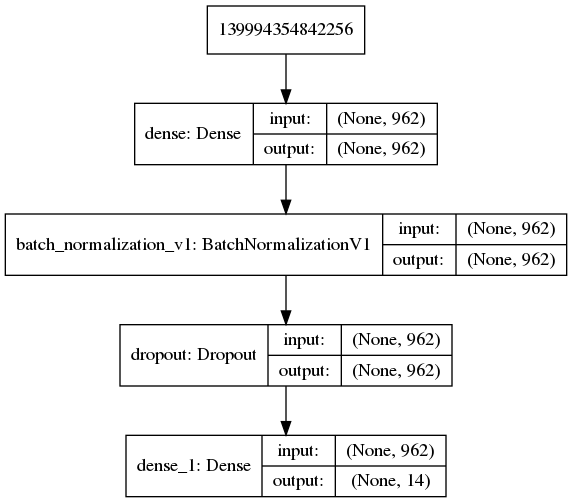

In [14]:
model = tf.keras.Sequential()

#model.add(tf.keras.layers.BatchNormalization())

#model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(len(data_columns), input_dim=len(data_columns), activation='sigmoid'))

#model.add(tf.keras.layers.BatchNormalization(axis=-1))
#model.add(tf.keras.layers.Dropout(0.2))
#model.add(tf.keras.layers.Dense(len(data_columns), activation='relu'))

#model.add(tf.keras.layers.LSTM(len(data_columns), input_shape=df_train[data_columns].shape, batch_size=1,
#                               return_sequences=True, dropout=0.1, recurrent_dropout=0.1))

model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(len(label_columns), activation='sigmoid'))

# summarize model
model.summary()

# sudo apt install python-pydot python-pydot-ng graphviz
file_path = 'images/model-3.png'
tf.keras.utils.plot_model(model, file_path, show_shapes=True, show_layer_names=True)
display(Image(filename=file_path))

In [15]:
optimizer = tf.train.AdamOptimizer(0.001)
#optimizer = tf.keras.optimizers.SGD(lr=0.03, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(
    optimizer=optimizer, 
    loss='mean_squared_error', 
    metrics=['mean_absolute_error']
)

Instructions for updating:
Use tf.cast instead.


In [16]:
x_train = tf.cast(df_train[data_columns].values, tf.float64)
y_train = tf.cast(df_train[label_columns].values, tf.float64)

In [17]:
checkpoint_path = os.path.join(DATA_DIR, 'cp.ckpt')
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, verbose=1)

In [18]:
history = model.fit(x_train, y_train, epochs=150, steps_per_epoch=20, callbacks = [cp_callback])

Instructions for updating:
Use tf.cast instead.
Epoch 1/150
19/20 [===========================>..] - ETA: 1s - loss: 18.0261 - mean_absolute_error: 1.8228
Epoch 00001: saving model to data/model-3/cp.ckpt
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.
20/20 [==============================] - 31s 2s/step - loss: 18.0095 - mean_absolute_error: 1.8194
Epoch 2/150
19/20 [===========================>..] - ETA: 0s - loss: 17.5074 - mean_absolute_error: 1.7154
Epoch 00002: saving model to data/model-3/cp.ckpt
20/20 [==============================] - 5s 253ms/step - loss: 17.5010 - mean_absolute_error: 1.7138
Epoch 3/150
19/20 [===========================>..] - ETA: 0s - loss: 17.3133 - mean_absolute_error: 1.6607
Epoch 00003: saving model to data/model-3/cp.ckpt
20/20 [==============================] - 5s 257ms/step - loss: 17.3108 - mean_absolute_error: 1.6598
Epoch 4/150
19/20 [===========================>..

Epoch 62/150
19/20 [===========================>..] - ETA: 0s - loss: 16.9407 - mean_absolute_error: 1.5506
Epoch 00062: saving model to data/model-3/cp.ckpt
20/20 [==============================] - 5s 261ms/step - loss: 16.9407 - mean_absolute_error: 1.5506
Epoch 63/150
19/20 [===========================>..] - ETA: 0s - loss: 16.9402 - mean_absolute_error: 1.5505
Epoch 00063: saving model to data/model-3/cp.ckpt
20/20 [==============================] - 5s 259ms/step - loss: 16.9402 - mean_absolute_error: 1.5505
Epoch 64/150
19/20 [===========================>..] - ETA: 0s - loss: 16.9395 - mean_absolute_error: 1.5504
Epoch 00064: saving model to data/model-3/cp.ckpt
20/20 [==============================] - 5s 261ms/step - loss: 16.9395 - mean_absolute_error: 1.5504
Epoch 65/150
19/20 [===========================>..] - ETA: 0s - loss: 16.9393 - mean_absolute_error: 1.5504
Epoch 00065: saving model to data/model-3/cp.ckpt
20/20 [==============================] - 5s 260ms/step - loss: 16

Epoch 94/150
19/20 [===========================>..] - ETA: 0s - loss: 16.9236 - mean_absolute_error: 1.5479
Epoch 00094: saving model to data/model-3/cp.ckpt
20/20 [==============================] - 5s 261ms/step - loss: 16.9236 - mean_absolute_error: 1.5479
Epoch 95/150
19/20 [===========================>..] - ETA: 0s - loss: 16.9227 - mean_absolute_error: 1.5478
Epoch 00095: saving model to data/model-3/cp.ckpt
20/20 [==============================] - 5s 260ms/step - loss: 16.9227 - mean_absolute_error: 1.5478
Epoch 96/150
19/20 [===========================>..] - ETA: 0s - loss: 16.9223 - mean_absolute_error: 1.5477
Epoch 00096: saving model to data/model-3/cp.ckpt
20/20 [==============================] - 5s 262ms/step - loss: 16.9223 - mean_absolute_error: 1.5477
Epoch 97/150
19/20 [===========================>..] - ETA: 0s - loss: 16.9222 - mean_absolute_error: 1.5477
Epoch 00097: saving model to data/model-3/cp.ckpt
20/20 [==============================] - 5s 260ms/step - loss: 16

Epoch 126/150
19/20 [===========================>..] - ETA: 0s - loss: 16.9132 - mean_absolute_error: 1.5464
Epoch 00126: saving model to data/model-3/cp.ckpt
20/20 [==============================] - 5s 258ms/step - loss: 16.9132 - mean_absolute_error: 1.5464
Epoch 127/150
19/20 [===========================>..] - ETA: 0s - loss: 16.9125 - mean_absolute_error: 1.5463
Epoch 00127: saving model to data/model-3/cp.ckpt
20/20 [==============================] - 5s 258ms/step - loss: 16.9125 - mean_absolute_error: 1.5463
Epoch 128/150
19/20 [===========================>..] - ETA: 0s - loss: 16.9128 - mean_absolute_error: 1.5464
Epoch 00128: saving model to data/model-3/cp.ckpt
20/20 [==============================] - 5s 258ms/step - loss: 16.9127 - mean_absolute_error: 1.5464
Epoch 129/150
19/20 [===========================>..] - ETA: 0s - loss: 16.9119 - mean_absolute_error: 1.5463
Epoch 00129: saving model to data/model-3/cp.ckpt
20/20 [==============================] - 5s 261ms/step - loss

Text(0.5, 0, 'epoch')

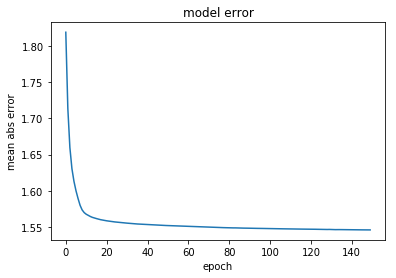

In [19]:
plt.plot(history.history['mean_absolute_error'])
#plt.plot(history.history['val_acc'])
plt.title('model error')
plt.ylabel('mean abs error')
plt.xlabel('epoch')

In [20]:
model.save(os.path.join(DATA_DIR, 'model_%s.h5' % datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

In [21]:
x_dev = tf.cast(df_dev[data_columns].values, tf.float32)
y_dev = tf.cast(df_dev[label_columns].values, tf.float32)

In [22]:
dev_predictions = model.predict(x_dev, steps=1)

In [23]:
df_dev_predictions = pandas.DataFrame(dev_predictions, columns=label_columns)

In [24]:
df_dev[data_columns].head()

,handwheelAngle,throttle,brake,clutch,engineSpeed,vNorth,vEast,vUp,horizontalSpeed,vxCG,...,deriv_190_chassisAccelRL,deriv_190_chassisAccelRR,deriv_190_deflectionFL,deriv_190_deflectionFR,deriv_190_deflectionRL,deriv_190_deflectionRR,deriv_190_wheelAccelFL,deriv_190_wheelAccelFR,deriv_190_wheelAccelRL,deriv_190_wheelAccelRR
112269,1.6,0.3,31.6,0.0,4416,4.74,32.59,1.52,32.93,32.97,...,1.805,-4.610,-0.002,-0.004,0.002,-0.003,0.10,-15.21,6.28,-4.42
113040,9.8,70.5,0.0,0.0,4338,38.17,3.32,5.03,38.32,38.64,...,3.267,0.588,0.005,0.005,0.000,0.003,16.67,-20.41,7.16,-31.40
170826,-1.3,53.0,0.0,67.6,4518,-27.50,-19.51,-0.22,33.72,33.72,...,-6.504,-5.788,-0.010,-0.003,0.000,0.018,-8.54,-13.44,-6.08,-1.21
226053,-6.1,0.9,0.0,24.5,204,0.02,-0.03,-0.07,0.03,0.01,...,0.029,0.098,0.000,0.000,0.000,0.000,-0.30,0.00,-0.29,0.01
69851,-33.1,0.8,0.0,24.5,204,0.00,0.01,0.03,0.01,-0.00,...,0.069,-0.098,0.000,0.000,0.000,0.000,0.10,0.10,0.10,-0.36


In [25]:
df_dev[label_columns].head()

,label_deriv_1_axCG,label_deriv_1_ayCG,label_deriv_1_pitchAngle,label_deriv_1_pitchRate,label_deriv_1_rollAngle,label_deriv_1_rollRate,label_deriv_1_vxCG,label_deriv_1_vyCG,label_deriv_1_wheelAccelFL,label_deriv_1_wheelAccelFR,label_deriv_1_wheelAccelRL,label_deriv_1_wheelAccelRR,label_deriv_1_yawAngle,label_deriv_1_yawRate
112269,-1.98,-2.81,0.04,0.03,0.06,3.22,-0.10,-0.05,12.85,-1.67,4.71,9.92,0.01,0.23
113040,2.70,4.26,-0.02,2.47,0.10,1.30,0.05,0.03,1.08,10.11,2.75,12.09,0.04,0.53
170826,-2.83,-3.30,-0.01,-4.80,-0.07,5.41,-0.03,-0.05,0.89,7.75,-9.62,-9.73,0.00,-0.23
226053,-0.01,-0.01,0.01,0.07,-0.01,0.40,0.00,0.00,-0.19,0.00,0.19,0.10,0.01,-0.02
69851,-0.01,0.02,0.00,0.33,0.00,-0.51,0.00,0.00,-0.39,0.00,-0.20,0.09,0.00,0.20


In [26]:
df_dev_predictions.head()

,label_deriv_1_axCG,label_deriv_1_ayCG,label_deriv_1_pitchAngle,label_deriv_1_pitchRate,label_deriv_1_rollAngle,label_deriv_1_rollRate,label_deriv_1_vxCG,label_deriv_1_vyCG,label_deriv_1_wheelAccelFL,label_deriv_1_wheelAccelFR,label_deriv_1_wheelAccelRL,label_deriv_1_wheelAccelRR,label_deriv_1_yawAngle,label_deriv_1_yawRate
0,0.000000,0.0,0.002601,0.987523,0.000147,0.000000,0.000026,0.000036,1.000000,1.000000e+00,9.991243e-01,9.079685e-01,0.000056,0.027528
1,1.000000,1.0,0.003884,0.131411,0.002188,0.000005,0.000934,0.001178,0.993446,9.999845e-01,0.000000e+00,1.000000e+00,0.011029,0.003731
2,0.000001,0.0,0.000039,0.000000,0.020344,1.000000,0.000014,0.000019,1.000000,9.999999e-01,1.000000e+00,6.526709e-05,0.000002,0.032809
3,0.000000,0.0,0.003196,0.000050,0.002121,0.278376,0.001922,0.001395,0.000000,1.788139e-07,7.974948e-01,1.490116e-07,0.007670,0.025552
4,0.000002,0.0,0.001591,0.061693,0.000848,0.000000,0.001602,0.001067,0.000000,7.361174e-06,8.940697e-08,1.490116e-07,0.003046,0.028778


In [27]:
error = df_dev.reset_index(drop=True)[label_columns] - df_dev_predictions[label_columns]

In [28]:
error.head()

,label_deriv_1_axCG,label_deriv_1_ayCG,label_deriv_1_pitchAngle,label_deriv_1_pitchRate,label_deriv_1_rollAngle,label_deriv_1_rollRate,label_deriv_1_vxCG,label_deriv_1_vyCG,label_deriv_1_wheelAccelFL,label_deriv_1_wheelAccelFR,label_deriv_1_wheelAccelRL,label_deriv_1_wheelAccelRR,label_deriv_1_yawAngle,label_deriv_1_yawRate
0,-1.980000,-2.81,0.037399,-0.957523,0.059853,3.220000,-0.100026,-0.050036,11.850000,-2.670000e+00,3.710876,9.012031,0.009944,0.202472
1,1.700000,3.26,-0.023884,2.338589,0.097812,1.299995,0.049066,0.028822,0.086554,9.110015e+00,2.750000,11.090000,0.028971,0.526269
2,-2.830001,-3.30,-0.010039,-4.800000,-0.090344,4.410000,-0.030014,-0.050019,-0.110000,6.750000e+00,-10.620000,-9.730065,-0.000002,-0.262809
3,-0.010000,-0.01,0.006804,0.069950,-0.012121,0.121624,-0.001922,-0.001395,-0.190000,-1.788139e-07,-0.607495,0.100000,0.002330,-0.045552
4,-0.010002,0.02,-0.001591,0.268307,-0.000848,-0.510000,-0.001602,-0.001067,-0.390000,-7.361174e-06,-0.200000,0.090000,-0.003046,0.171222
